# Gradient descent -- SUGRA potential with 3 parameters

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

2024-12-04 20:09:13.553020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 20:09:13.578940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 20:09:13.585016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 20:09:13.601140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 20:09:14.772740: W tensorflow/compiler/tf2

In [18]:
##############################
# Parameters
##############################

potential = "pot_3_param"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 10000                                       # Number of randomly initialised points
n_steps = 35000                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-3)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()

In [19]:
print(time)

2024_12_04_at_19_35_07


In [20]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/home/camille/Documents/Science/MLFlatDirections/Output/' already exists.


In [21]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

3
Help on function V in module pot_3_param:

V(x)
    0.5 * (4 + tf.exp(6 * x1) + tf.exp(-2 * x1 -4 * (3 ** -0.5) * x2) -2 * (tf.exp(2 * x1 -2 * (3 ** -0.5) * x2)) -4 * (tf.exp(-2 * x1 -((3 ** -0.5) * x2))) -4 * (tf.exp(2 * x1 + (3 ** -0.5) * x2)) -4 * (x3 ** 2) + 2 * (tf.exp(-4 * x1 -2 * (3 ** -0.5) * x2)) * (x3 ** 2) + 2 * (tf.exp(4 * x1 + 2 * (3 ** -0.5) * x2)) * (x3 ** 2) + (tf.exp(-6 * x1)) * (x3 ** 4) -2 * (tf.exp(-2 * x1 + 2 * (3 ** -0.5) * x2)) * (x3 ** 4) + (tf.exp(2 * x1 + 4 * (3 ** -0.5) * x2)) * (x3 ** 4))



In [22]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [23]:
# Randomly initialize the points
x = tf.Variable(spread*np.random.rand(n_points, dim)-(spread/2), dtype=tf.float32)


loss_history = []


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Update the information in info file
    if step % 500 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

In [15]:
# # Randomly initialize the points
# x = tf.Variable(np.random.rand(n_points, 3)+1, dtype=tf.float32)


# loss_history = []

# update_opt = False


# # Learning loop 
# for step in range(n_steps):  
#     with tf.GradientTape() as tape:
#         loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
#         loss_history.append(loss)
    
#     # Compute ||∇V||^2 with respect to x
#     gradients = tape.gradient(loss, [x])
        
#     # Apply gradient descent for all points
#     optimizer.apply_gradients(zip(gradients, [x]))
    
#     # Updates of optimizer
#     if update_opt and step % n_steps_opt ==0 :
#         print("Reinitializing the optimizer")
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)

#     if step == step_stop_opt:
#         update_opt = False
    
#     if (step - step_stop_opt)%(3*n_steps_opt) == 0:
#         alpha = alpha/10
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)


#     # Update the information in info file
#     if step % 500 == 0:
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         f_info.flush()
        
#     if np.log(loss.numpy())/np.log(10)<-8: 
#         f_info.write("\n\nConverged enough") 
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         break

# f_info.close()

# # Saving loss and final cloud of points
# np.save(data_file,x)
# np.save(loss_file,loss_history)

## Results

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

2024-12-12 15:03:40.790706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 15:03:40.808657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 15:03:40.813895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 15:03:40.827003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 15:03:41.852076: W tensorflow/compiler/tf2

### Functions

In [2]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [3]:
def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.show()
    
# def triangular_plot(chains,figname):
#     data=chains
#     nsteps,ndim=chains.shape
#     fig = plt.figure(figsize=(20,20))
#     for i in range(ndim):
#         ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
#         ax.hist(data[:,i], 100, color="k", histtype="step")
#         ax.set_title(f"x{i+1} counts")

#     for i in range(ndim):
#         for j in range(i):
#             ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
#             counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
#             plt.colorbar(image)
#             ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
#             ax.set_xlabel(f'x{j+1}')
#             ax.set_ylabel(f'x{i+1}')
#     plt.savefig(figname)
#     plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [38]:
# Loading the potential
potential = "pot_3_param"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_04_at_19_35_07'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [39]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

In [40]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 1
Number of points with ||∇V||^2 > 0.001 : 24
Number of points with ||∇V||^2 > 0.0001 : 117
Number of points with ||∇V||^2 > 1e-05 : 330
Number of points with ||∇V||^2 > 1e-06 : 688
Number of points with ||∇V||^2 > 1e-07 : 1291
Number of points with ||∇V||^2 > 1e-08 : 2037
Number of points with ||∇V||^2 > 1e-09 : 2890
Number of points with ||∇V||^2 > 1e-10 : 3741
Number of points with ||∇V||^2 > 1e-11 : 4593
Number of points with ||∇V||^2 > 1e-12 : 5421
Number of points with ||∇V||^2 > 1e-13 : 6611
Number of points with ||∇V||^2 > 1e-14 : 8027


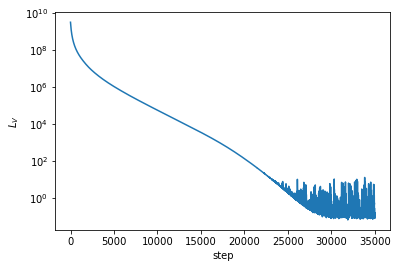

In [42]:
plt.figure(1)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$L_{V}$')
plt.show()

<Figure size 432x288 with 0 Axes>

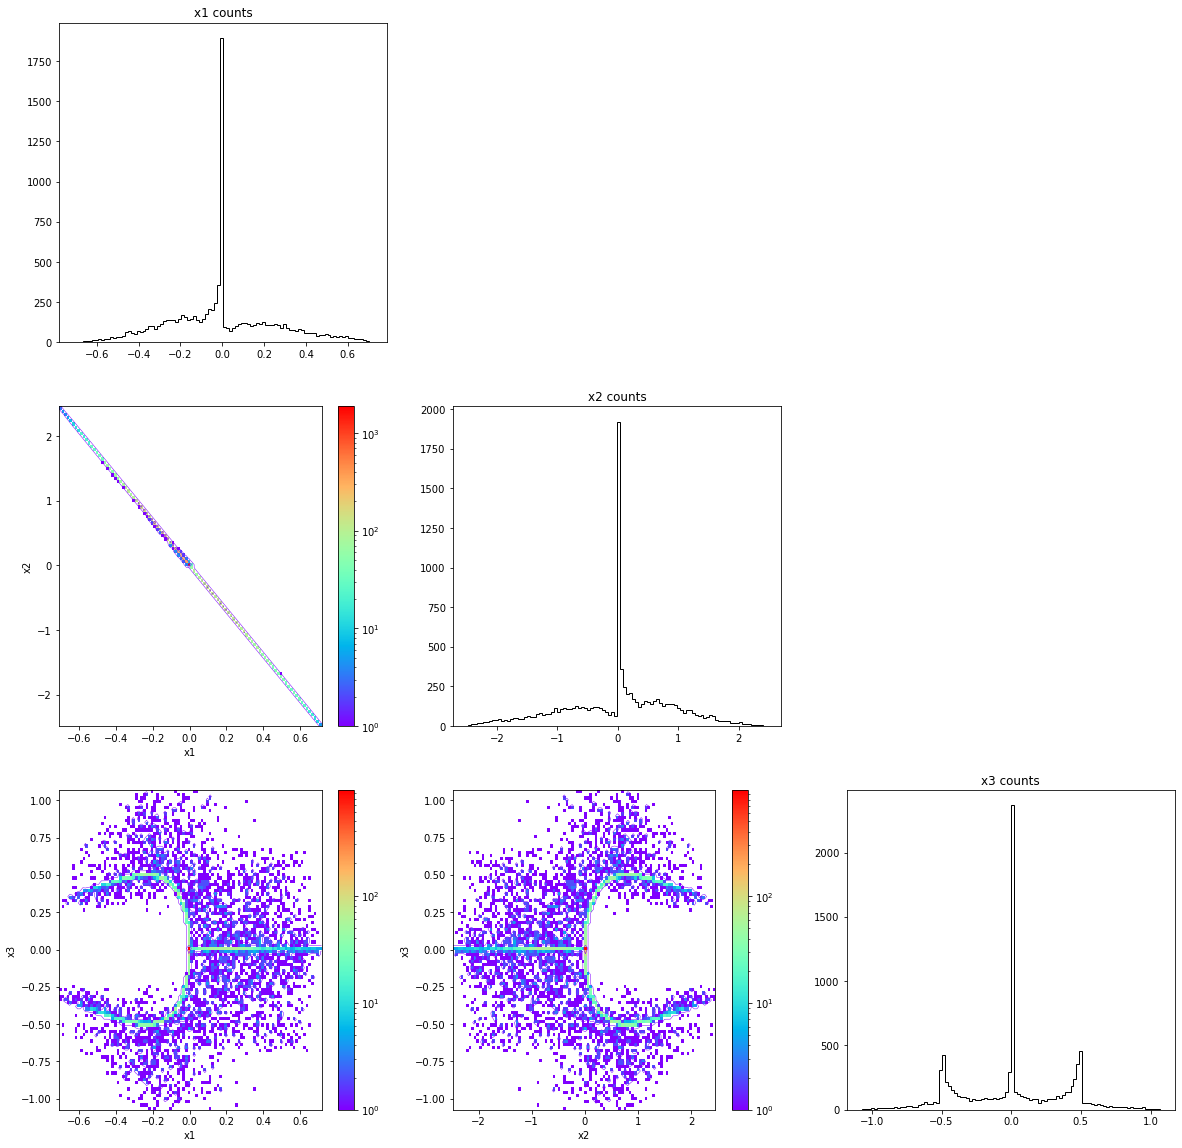

In [43]:
plt.figure(1)
triangular_plot(x.numpy())


## Autoencoder

In [4]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

In [5]:
# Loading the potential
potential = "pot_3_param"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_04_at_19_35_07'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'
AE_loss_file = out_dir + 'AE_all_loss' + attempt + '.npy'
AE_val_loss_file = out_dir + 'AE_all_val_loss' + attempt + '.npy'

In [6]:
x = np.load(data_file)
loss_history = np.load(loss_file)

In [7]:
x_train, x_test = train_test_split(x, test_size=0.15, random_state=42)

In [8]:
print(f'shape of total set of points: {x.shape}')
print(f'shape of training set of points: {x_train.shape}')
print(f'shape of validation set of points: {x_test.shape}')

shape of total set of points: (10000, 3)
shape of training set of points: (8500, 3)
shape of validation set of points: (1500, 3)


### Latent dimension = 1

In [30]:
input_dim = dim  
latent_dim = 1  

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [31]:
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,604 (6.27 KB)

 Trainable params: 1,604 (6.27 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs = 6000
history_AE_1 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7609 - val_loss: 0.5960
Epoch 2/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5802 - val_loss: 0.4754
Epoch 3/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4724 - val_loss: 0.4020
Epoch 4/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4067 - val_loss: 0.3610
Epoch 5/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3684 - val_loss: 0.3409
Epoch 6/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3484 - val_loss: 0.3319
Epoch 7/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3400 - val_loss: 0.3286
Epoch 8/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3383 - val_loss: 0.3277
Epoch 9/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3339 - val_loss: 0.3275
Epoch 10/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3317 - val_loss: 0.3276
Epoch 11/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3326 - val_loss: 0.3275
Epoch 12/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [33]:
autoencoder_1 = autoencoder
encoder_1 = models.Model(inputs,encoded)
decoder_1 = models.Model(encoded,decoded)

In [60]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

What is the histogram representing?

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


(array([ 26.,  40., 106., 186., 509., 296., 210.,  82.,  33.,  12.]),
 array([-0.9246216 , -0.63959384, -0.35456607, -0.06953832,  0.21548943,
         0.5005172 ,  0.78554493,  1.0705727 ,  1.3556005 ,  1.6406282 ,
         1.925656  ], dtype=float32),
 <BarContainer object of 10 artists>)

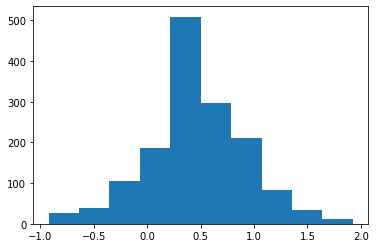

In [12]:
# test autoencoder
encoded_points = encoder_1.predict(x_test)

plt.hist(encoded_points)

### Latent dimension = 2

In [35]:
input_dim = dim  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [36]:
autoencoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621 (6.33 KB)

 Trainable params: 1,621 (6.33 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
epochs = 6000
history_AE_2 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1118 - val_loss: 0.8575
Epoch 2/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8011 - val_loss: 0.6396
Epoch 3/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6135 - val_loss: 0.5028
Epoch 4/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4878 - val_loss: 0.4206
Epoch 5/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4113 - val_loss: 0.3741
Epoch 6/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3764 - val_loss: 0.3494
Epoch 7/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3518 - val_loss: 0.3372
Epoch 8/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3509 - val_loss: 0.3316
Epoch 9/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3401 - val_loss: 0.3293
Epoch 10/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3373 - val_loss: 0.3284
Epoch 11/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3395 - val_loss: 0.3281
Epoch 12/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [38]:
autoencoder_2 = autoencoder
encoder_2 = models.Model(inputs,encoded)
decoder_2 = models.Model(encoded,decoded)

In [39]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

In [15]:
# test autoencoder
encoded_points = encoder_2.predict(x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


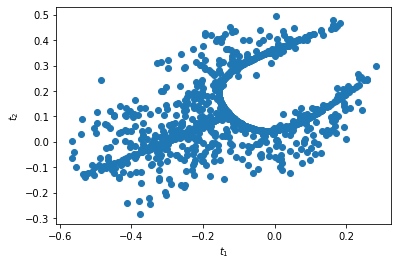

In [17]:
plt.scatter(encoded_points[:,0],encoded_points[:,1])
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()
# plt.savefig('../LaTeX/Notes/Figures/encoded_Higgs_l2.png')

Test decoder

In [18]:
# Randomly initialize the points
spread=0.8
t = spread*np.random.rand(1000, 2)-(spread/2)

plt.scatter(t[:,0],t[:,1])
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')

Text(0, 0.5, '$t_2$')

In [19]:
decoded_points = decoder_2.predict(t)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [20]:
plt.figure(1)
triangular_plot(decoded_points)

<Figure size 432x288 with 0 Axes>

In [74]:
AE_file = out_dir + 'AE_l2' + attempt + '.keras'

In [76]:
autoencoder_2.save(AE_file)

### Latent dimension = 3

In [45]:
input_dim = dim  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [46]:
autoencoder.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,638 (6.40 KB)

 Trainable params: 1,638 (6.40 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
epochs = 6000
history_AE_3 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3866 - val_loss: 0.3410
Epoch 2/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3448 - val_loss: 0.3295
Epoch 3/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3378 - val_loss: 0.3281
Epoch 4/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3323 - val_loss: 0.3278
Epoch 5/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3317 - val_loss: 0.3278
Epoch 6/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3402 - val_loss: 0.3279
Epoch 7/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3315 - val_loss: 0.3280
Epoch 8/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3371 - val_loss: 0.3279
Epoch 9/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3396 - val_loss: 0.3279
Epoch 10/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3405 - val_loss: 0.3278
Epoch 11/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3353 - val_loss: 0.3275
Epoch 12/6000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [48]:
autoencoder_3 = autoencoder
encoder_3 = models.Model(inputs,encoded)
decoder_3 = models.Model(encoded,decoded)

In [53]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

# plt.savefig('Figures/lossAE_3_param.png')

plt.show()

In [67]:
loss_history_all = np.array([history_AE_1.history['loss'],history_AE_2.history['loss'],history_AE_3.history['loss']])
val_loss_history_all = np.array([history_AE_1.history['val_loss'],history_AE_2.history['val_loss'],history_AE_3.history['val_loss']])

np.save(AE_loss_file,loss_history_all)
np.save(AE_val_loss_file,val_loss_history_all)

In [ ]:
# test autoencoder
encoded_points = encoder_3.predict(x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


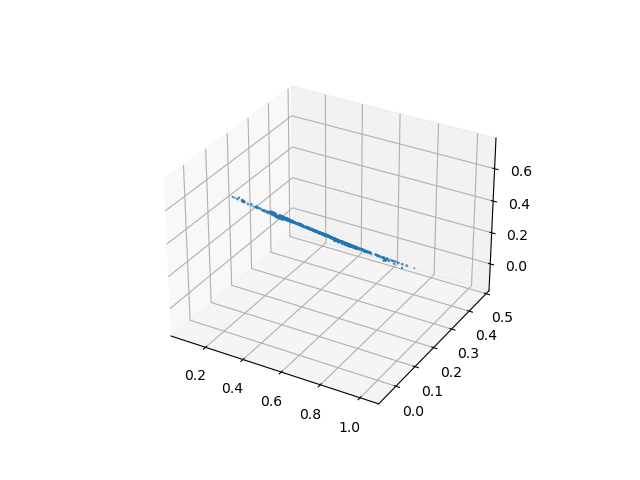

In [ ]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(encoded_points[:,0], encoded_points[:,1], encoded_points[:,2],s=0.5)

In [ ]:
%matplotlib inline

### Results and analysis for l=2

In [9]:
loss_history_all = np.load(AE_loss_file)
val_loss_history_all = np.load(AE_val_loss_file)

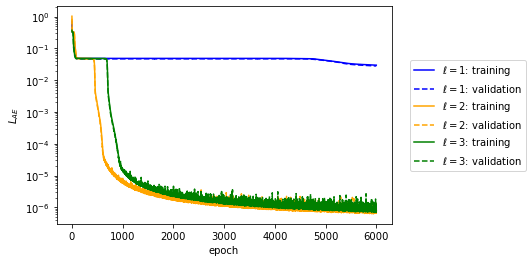

In [10]:
plt.plot(loss_history_all[0], label='$\ell=1$: training',color='blue')
plt.plot(val_loss_history_all[0], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(loss_history_all[1], label='$\ell=2$: training',color='orange')
plt.plot(val_loss_history_all[1], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(loss_history_all[2], label='$\ell=3$: training',color='green')
plt.plot(val_loss_history_all[2], label='$\ell=3$: validation',color='green',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

plt.show()

Plot nice figure and save it.

In [77]:
# # import python library for nice plots
# from figure import *

# ### FIGURE ###
# #dictionnaire pour les couleurs et points
# (couleur, mark, size) = defsize()

# #creation figure
# newfig()
# ax = plt.gca()

# sub = plt.subplot(1,1,1)

# plt.plot(loss_history_all[0], label='$\ell=1$: training',color='blue')
# plt.plot(val_loss_history_all[0], label='$\ell=1$: validation',color='blue',linestyle='--')
# plt.plot(loss_history_all[1], label='$\ell=2$: training',color='orange')
# plt.plot(val_loss_history_all[1], label='$\ell=2$: validation',color='orange',linestyle='--')
# plt.plot(loss_history_all[2], label='$\ell=3$: training',color='green')
# plt.plot(val_loss_history_all[2], label='$\ell=3$: validation',color='green',linestyle='--')

# plt.yscale('log')
# plt.xlabel(r'Epoch')
# plt.ylabel(r'$L_{AE}$')

# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

# #save the figure
# figsave('Figures/lossAE_3_param')   #changer le nom de la figure

# plt.show()

In [11]:
AE_file = out_dir + 'AE_l2' + attempt + '.keras'

autoencoder_2 = models.load_model(AE_file)
autoencoder_2.summary()

I0000 00:00:1734012242.021888 1161441 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734012242.069832 1161441 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734012242.070166 1161441 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734012242.071636 1161441 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.01 KB)

 Trainable params: 1,621 (6.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,244 (12.68 KB)

In [12]:
# Encoder
inputs = layers.Input(shape=(dim,))
encoded = autoencoder_2.layers[1](inputs)
encoded = autoencoder_2.layers[2](encoded)
encoded = autoencoder_2.layers[3](encoded)
encoded = autoencoder_2.layers[4](encoded)

encoder_2 = Model(inputs=inputs, outputs=encoded)

encoder_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 810 (3.16 KB)

 Trainable params: 810 (3.16 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Decoder
decoded = autoencoder_2.layers[5](encoded)
decoded = autoencoder_2.layers[6](decoded)
decoded = autoencoder_2.layers[7](decoded)
decoded = autoencoder_2.layers[8](decoded)

decoder_2 = Model(inputs=encoded, outputs=decoded)

decoder_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_20CLONE            │ (None, 2)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 811 (3.17 KB)

 Trainable params: 811 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# test autoencoder
encoded_points = encoder_2.predict(x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


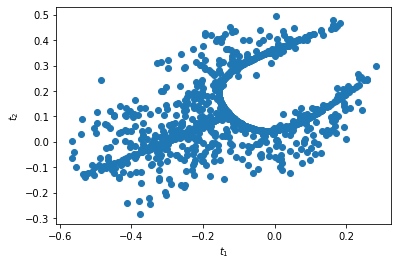

In [ ]:
plt.scatter(encoded_points[:,0],encoded_points[:,1])
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.show()
# plt.savefig('../LaTeX/Notes/Figures/encoded_Higgs_l2.png')

Test decoder

Text(0, 0.5, '$t_2$')

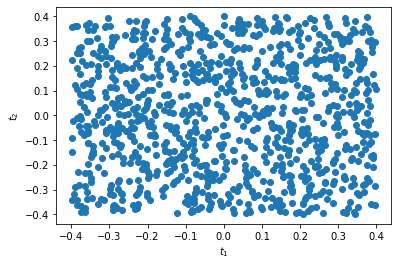

In [ ]:
# Randomly initialize the points
spread=0.8
t = spread*np.random.rand(1000, 2)-(spread/2)

plt.scatter(t[:,0],t[:,1])
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')

In [ ]:
decoded_points = decoder_2.predict(t)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


<Figure size 432x288 with 0 Axes>

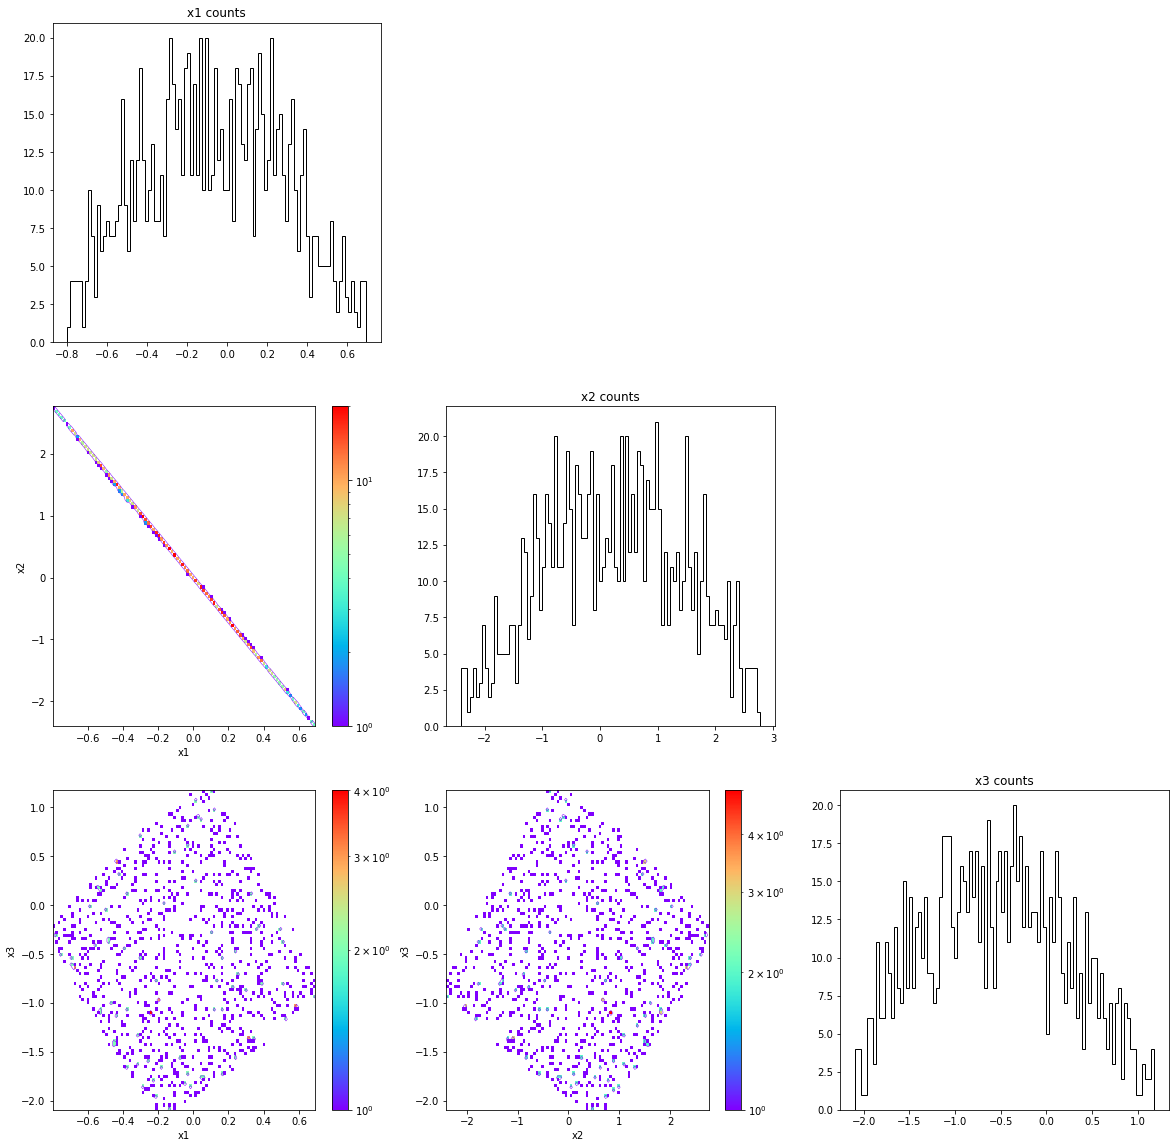

In [ ]:
plt.figure(1)
triangular_plot(decoded_points)